In [37]:
%load_ext watermark
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [38]:
%watermark -a "Cameron Brien" -d -v -p numpy,pandas,matplotlib.pyplot,seaborn

Cameron Brien 2019-06-13 

CPython 3.6.4
IPython 6.2.1

numpy 1.16.2
pandas 0.23.4
matplotlib.pyplot 2.2.2
seaborn 0.9.0


In [39]:
# reading the data
df = pd.read_csv("train.csv")
df_test = pd.read_csv('test.csv')

In [40]:
# checking the contents of the data
df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [41]:
# checking data types of the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB


In [42]:
# dropping the ID_code column
df.drop('ID_code', axis = 1, inplace=True)

In [43]:
# checking for columns that have null values
null_counts = df.isnull().sum()
null_counts[null_counts > 0].sort_values(ascending=False)

Series([], dtype: int64)

There are no null values in this data set and all of the data is in an appropriate format, so there is no action necessary before working with the data.

In [44]:
# checking for correlation between columns and the target
columns = df.drop('target', axis = 1).columns
target = df['target']
corr = []
for x in range(len(columns)):
    corr.append(np.corrcoef(df[columns[x]], target)[0][1])

In [45]:
# checking for max and mean correlations
print(max(np.absolute(corr)))
print(np.mean(np.absolute(corr)))

0.08091733227454602
0.027858669714875276


This is a very low max correlation value, indicating that none of the columns have a strong individual correlation with the target variable. The mean value is also very low, showing that most columns have a very small correlation with the target.

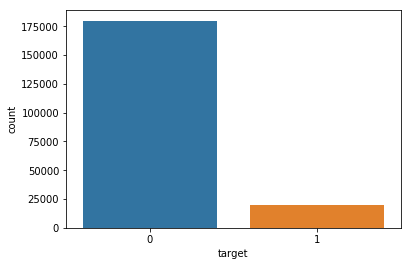

In [46]:
# Checking the target distribution
sns.countplot(df['target'])

This plot shows that the data is heavily weighted towards one of the categories. I will have to use weights to help counteract the effect of this unbalanced data.

C:\Users\Cam\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


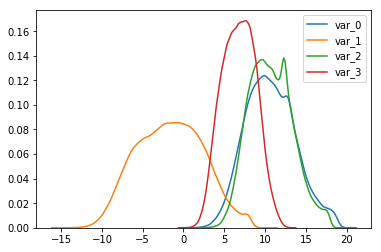

In [47]:
# plotting some of the columns
sns.kdeplot(df['var_0'])
sns.kdeplot(df['var_1'])
sns.kdeplot(df['var_2'])
sns.kdeplot(df['var_3'])

C:\Users\Cam\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


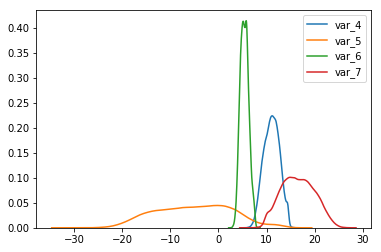

In [48]:
# plotting some of the columns
sns.kdeplot(df['var_4'])
sns.kdeplot(df['var_5'])
sns.kdeplot(df['var_6'])
sns.kdeplot(df['var_7'])

We can see from these graphs that a lot of the data is bimodal or trimodal. This makes me think that the data may be categorical data with noise added to it to obscure the categories. This leads me to think that a tree based algorithm would do well on this data.

### Machine Learning

In [49]:
# Performing the imports 
from sklearn.model_selection import train_test_split

# Splitting the data into training and testing sets
X = df.drop('target', axis = 1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

I am choosing to use light GBM here because it is a powerful tree based algorithm that does well with data like this. I am averaging the results from five different models with different hyperparameters because I have found that it increases the score.

In [50]:
# Here I am averaging the results from five models, because this performed best for me in testing


# Creating the dataset with training data
d_train = lgb.Dataset(X_train, y_train)

# Setting up learning rates, bagging frequencies, and weights for the models
learning_rates = [0.014077 , 0.0140815, 0.014086 , 0.0140905, 0.014095 ]
bagging_freq = [60, 50, 50, 75, 75]
weight = [1, 3, 4, 2, 1] # Using weights to deal with imbalanced data


# Creating an empty list for predictions
l = []

# Running the five models
for x in range(5):
    param = {
        'scale_pos_weight':weight[x],
        'max_bin':500,
        'bagging_freq': bagging_freq[x],
        'bagging_fraction': 0.335,
        'boost_from_average':'false',
        'boost': 'gbdt',
        'feature_fraction': 0.081,
        'learning_rate': learning_rates[x],
        'max_depth': -1,
        'metric':'auc',
        'min_data_in_leaf': 80,
        'min_sum_hessian_in_leaf': 10.0,
        'num_leaves': 13,
        'num_threads': 8,
        'tree_learner': 'serial',
        'objective': 'binary', 
        'verbosity': -1}
    clf = lgb.train(param, d_train, 6000) #try increase

    y_pred = clf.predict(X_test)
    l.append(y_pred)

# Creating a list for the final averages
pred_proba = []

# Averaging the models
for x in range(len(l[0])):
    pred_proba.append(np.average([l[0][x],l[1][x],l[2][x],l[3][x],l[4][x]]))

# Printing the test results
print("Roc auc score: {}".format(roc_auc_score(y_test, pred_proba)))

Roc auc score: 0.8999461430676367


This is a good score, but I wanted to see if it would be improved by reducing the dimensionality through pca

In [51]:
# Importing 
from sklearn.decomposition import PCA

# Getting a pca model for 95% of the variance in the data
pca = PCA(.95)

# Creating an array with the transformed data
df_principal_comp = pca.fit_transform(df.drop('target', axis=1))

# Printing the number of components in this data frame
print(pca.n_components_)

111


In [52]:
# Splitting the data into training and testing sets
X = df_principal_comp
y = df['target']

X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X, y, test_size=0.2, random_state=123)

In [53]:
# Creating the dataset with training data
d_train = lgb.Dataset(X_train_pca, y_train_pca)

# Setting up learning rates, bagging frequencies, and weights for the models
learning_rates = [0.014077 , 0.0140815, 0.014086 , 0.0140905, 0.014095 ]
bagging_freq = [60, 50, 50, 75, 75]
weight = [1, 3, 4, 2, 1]


# Creating an empty list for predictions
l = []

for x in range(5):
    param = {
        'scale_pos_weight':weight[x],
        'max_bin':500,
        'bagging_freq': bagging_freq[x],
        'bagging_fraction': 0.335,
        'boost_from_average':'false',
        'boost': 'gbdt',
        'feature_fraction': 0.081,
        'learning_rate': learning_rates[x],
        'max_depth': -1,
        'metric':'auc',
        'min_data_in_leaf': 80,
        'min_sum_hessian_in_leaf': 10.0,
        'num_leaves': 13,
        'num_threads': 8,
        'tree_learner': 'serial',
        'objective': 'binary', 
        'verbosity': -1}
    clf = lgb.train(param, d_train, 6000) #try increase

    y_pred = clf.predict(X_test_pca)
    l.append(y_pred)

# Creating a list for the final averages
pred_proba = []
# Averaging the models
for x in range(len(l[0])):
    pred_proba.append(np.average([l[0][x],l[1][x],l[2][x],l[3][x],l[4][x]]))
    
# Printing the test results
print("Roc auc score: {}".format(roc_auc_score(y_test, pred_proba)))

Roc auc score: 0.815513018549339


I performed pca with 95% and 99% of the variance and in both cases saw a significant decline in performance indicating that all of the columns are important to this dataset. This dataset may actually be comprised of the principal components of another larger dataset or the interactions of the columns may be important for making predictions. These possibilities would explain the sharp loss of accuracy found when reducing the dimensionality of it.